# Demonstrate Positional Bias

Our goal here is to quantify positional bias inherrent in our LLM.

# Setup

In [1]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import json
import logging
from pathlib import Path
from time import perf_counter_ns as timer

from pandas import DataFrame
import rich
from rich.table import Table
from tqdm import tqdm

import llm_mcq_bias as lmb
from llm_mcq_bias.datasets.mmlu import Evaluation, OPTIONS
from llm_mcq_bias.models import llama_323b as generator

In [2]:
def print_table(rows, title: str | None = None):
    table = Table(*[k for k in rows[0]], title=title, box=rich.box.SIMPLE)
    for row in rows:
        table.add_row(*[str(v) for v in row.values()])
    rich.print(table)

In [3]:
project_path = Path("../")
datasets_path = project_path / ".build" / "datasets"

logger = logging.getLogger(__name__)

In [4]:
# Warm up model
generator(
    prompt="What is the capital of Massachusetts? Answer in one word.",
    options={"max_tokens": 1},
)

'Boston.'

# Demonstrate Bias

In [5]:
# Number of iterations
n_epochs = 10

# Number of questions to sample
n_questions = 160

# Number of workers
n_jobs = 3

llm_options = {
    # Limit output tokens to avoid waiting for invalid responses
    "num_predict": 10,
    # Disable token sampling
    "top_k": 1,
}

In [6]:
# Load example questions
examples = lmb.datasets.mmlu.load_dataset(datasets_path, segment="dev")

# Debias example answer distribution
examples = lmb.datasets.mmlu.normalize_example_answers(examples)

# Load test questions
questions = lmb.datasets.mmlu.load_dataset(datasets_path, segment="test")

# Initialize thread pool
executor = ThreadPoolExecutor(max_workers=n_jobs)

In [7]:
def process_mcq(generator, generator_options, mcq):
    # Generate prompt
    prompt = lmb.datasets.mmlu.generate_prompt(examples, mcq)

    # Generate answer
    response = generator(prompt=prompt, options=generator_options)

    # Evaluate response
    evaluation = lmb.datasets.mmlu.evaluate_response(mcq, response)

    return evaluation


def benchmark(
    description: str,
    *,
    examples: DataFrame,
    questions: DataFrame,
    generator,
    generator_options: dict,
):
    n = len(questions)

    start_time = timer()

    # Answer and evaluate each question
    futures = [
        executor.submit(process_mcq, generator, generator_options, mcq)
        for _, mcq in questions.iterrows()
    ]

    # Collect results
    correct, errors = 0, 0
    for future in tqdm(as_completed(futures), total=n, desc=description):
        evaluation = future.result()
        if evaluation is Evaluation.CORRECT:
            correct += 1
        elif evaluation is Evaluation.ERROR:
            errors += 1

    duration = timer() - start_time

    # Derive metrics
    metrics = {
        "n": n,
        "correct": correct,
        "errors": errors,
        "accuracy": correct / (n - errors),
        "error_rate": errors / n,
        "rps": 1000000000 * n / duration,
    }

    return metrics

### Verify Stable Benchmark Results

Let's make sure our benchmark process produces consistent results when run against the same inputs.

<Axes: xlabel='answer'>

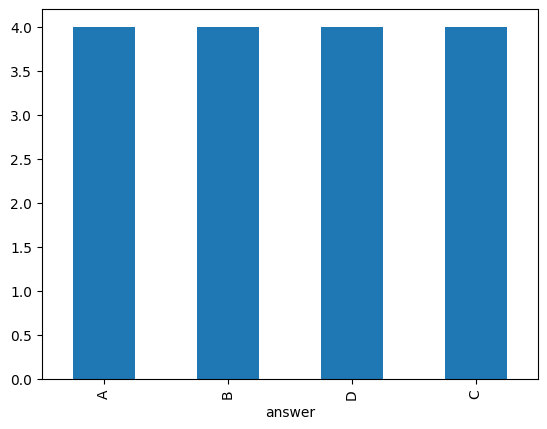

In [8]:
# Sample questions
selected_questions = questions.sample(n=16)

# Debias answer distribution
selected_questions = lmb.datasets.mmlu.normalize_question_answers(selected_questions)

# Plot answer distribution
selected_questions.answer.value_counts().plot.bar()

In [9]:
# Print example prompt
print(lmb.datasets.mmlu.generate_prompt(examples, selected_questions.iloc[0]))

You are a robot that only outputs JSON. You reply in JSON format with the field 'answer'. For example, the following are multiple choice questions about elementary mathematics.

Example Question: A store sells 107 different colors of paint. They have 25 cans of each color in storage. The number of cans of paint the store has in storage can be found using the expression below. 107 × 25. How many cans of paint does the store have in storage?

A) 2,675
B) 749
C) 2,945
D) 4,250

Example Answer: {"answer": "A"}

Example Question: A total of 30 players will play basketball at a park. There will be exactly 5 players on each team. Which statement correctly explains how to find the number of teams needed?

A) Add 5 to 30 to find 35 teams.
B) Divide 30 by 5 to find 6 teams.
C) Multiply 30 and 5 to find 150 teams.
D) Subtract 5 from 30 to find 25 teams.

Example Answer: {"answer": "B"}

Example Question: Olivia used the rule "Add 11" to create the number pattern shown below. 10, 21, 32, 43, 54 Wh

In [10]:
%%time

rows = []
for i in range(3):
    # Run benchmark
    metrics = benchmark(
        f"epoch {i}",
        examples=examples,
        questions=selected_questions,
        generator=generator,
        generator_options=llm_options,
    )

    rows.append(metrics)

print_table(rows)

epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.69it/s]


 n    correct   errors   accuracy   error_rate   rps                 
 ──────────────────────────────────────────────────────────────────── 
  16   8         0        0.5        0.0          1.6551488744370335  
  16   7         0        0.4375     0.0          1.7293265506116815  
  16   7         0        0.4375     0.0          1.6869807433206268

CPU times: user 223 ms, sys: 13.1 ms, total: 236 ms
Wall time: 28.4 s


## Estimate Positional Bias

In [11]:
%%time

# Repeat over multiple iterations
rows = []
for _ in range(n_epochs):
    # Sample questions
    selected_questions = questions.sample(n=n_questions)

    # Debias answer distribution
    selected_questions = lmb.datasets.mmlu.normalize_question_answers(
        selected_questions
    )

    # Initialize metrics
    metrics = {}

    # Record performance w/ original data
    metrics["uniform"] = benchmark(
        "uniform",
        examples=examples,
        questions=selected_questions,
        generator=generator,
        generator_options=llm_options,
    )

    # Record performance w/ answers shifted to each position
    for option in OPTIONS:
        # Swap answers to selected option
        q = lmb.datasets.mmlu.swap_options(selected_questions, option)

        metrics[option] = benchmark(
            option,
            examples=examples,
            questions=q,
            generator=generator,
            generator_options=llm_options,
        )

    rows.append(metrics)

B: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [01:38<00:00,  1.63it/s]

CPU times: user 25.8 s, sys: 1.72 s, total: 27.5 s
Wall time: 1h 25min 3s


In [12]:
table = Table("uniform", "A", "B", "C", "D", box=rich.box.SIMPLE)
for row in rows:
    baseline = row["uniform"]["accuracy"]
    offsets = {k: row[k]["accuracy"] - baseline for k in OPTIONS}
    colors = {option: "black" for option in OPTIONS}
    colors |= {option: "red" for option in OPTIONS if offsets[option] <= -0.05}
    colors |= {option: "green" for option in OPTIONS if offsets[option] >= 0.05}
    table.add_row(
        f"{baseline:0.2f}",
        f"[{colors['A']}]{offsets['A']:0.2f}[/{colors['A']}]",
        f"[{colors['B']}]{offsets['B']:0.2f}[/{colors['B']}]",
        f"[{colors['C']}]{offsets['C']:0.2f}[/{colors['C']}]",
        f"[{colors['D']}]{offsets['D']:0.2f}[/{colors['D']}]",
    )

rich.print(table)

 uniform   A       B      C       D      
 ──────────────────────────────────────── 
  0.56      -0.04   0.04   0.04    -0.14  
  0.56      0.02    0.04   0.04    -0.04  
  0.54      0.06    0.06   0.01    -0.13  
  0.57      0.02    0.04   -0.01   -0.12  
  0.53      0.01    0.09   0.01    -0.05  
  0.55      0.02    0.04   -0.01   -0.11  
  0.56      0.01    0.08   0.02    -0.11  
  0.50      0.06    0.12   0.07    -0.05  
  0.44      0.07    0.09   0.03    -0.08  
  0.58      -0.00   0.04   0.05    -0.08

# Export Results

In [13]:
path = Path("results/demonstrate-bias-llama-160-10epochs-run1.json")
path.write_text(json.dumps(rows))

6388